In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
from imutils import paths
from sklearn.datasets import make_classification
from sklearn.cluster import MeanShift
from matplotlib import pyplot
import random
import pickle
import csv
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import scipy
from sklearn.cluster import KMeans
from PIL import Image
from skimage.morphology import disk, opening
from pylab import *

## Canny - Edge Detection

In [2]:
def auto_canny(image, sigma=0.5):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    
    # return the edged image
    return edged

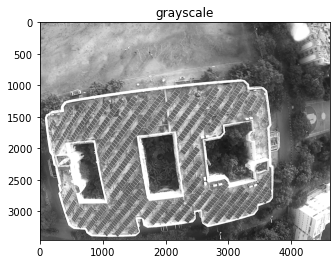

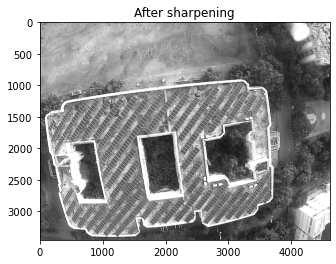

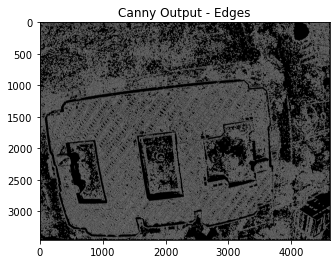

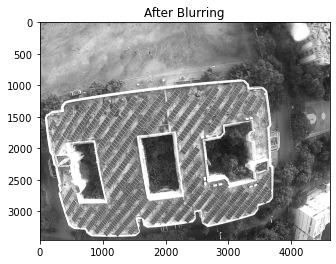

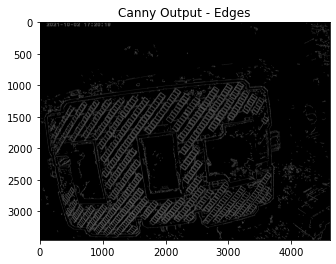

In [4]:
# path = '/home/src21/Documents/full_view/20211002_172019A.jpg'
path = './Nilgiri_top_face/full_view/20211002_172019A.jpg'
img = cv2.imread(path) #height = 69 meters
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.title('grayscale')
plt.imshow(gray, cmap='gray')

##Edge preservation and Noise reduction
blur = cv2.bilateralFilter(gray, 5, 75, 75)
#blur = cv2.GaussianBlur(gray, (5, 5), 0)

kernel_sharp = np.array((
[-2, -2, -2],
[-2, 17, -2],
[-2, -2, -2]), dtype='int')
sharpened_img = cv2.filter2D(blur, -1, kernel_sharp)

canny = auto_canny(sharpened_img)

plt.figure()
plt.title('After sharpening')
plt.imshow(sharpened_img, cmap='gray')

plt.figure()
plt.title('Canny Output - Edges')
plt.imshow(canny, cmap='gray')
plt.show()

canny = auto_canny(blur)

plt.figure()
plt.title('After Blurring')
plt.imshow(sharpened_img, cmap='gray')

plt.figure()
plt.title('Canny Output - Edges')
plt.imshow(canny, cmap='gray')
plt.show()

# canny = auto_canny(gray)

# plt.figure()
# plt.title('No blurring or sharpening')
# plt.imshow(sharpened_img, cmap='gray')

# plt.figure()
# plt.title('Canny Output - Edges')
# plt.imshow(canny, cmap='gray')
# plt.show()

## Structured Forests - Edge Detection

In [5]:
edge_detector = cv2.ximgproc.createStructuredEdgeDetection('./structuredForestModel/model.yml')

In [8]:
src = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sf = edge_detector.detectEdges(np.float32(src))

## Contour Approximation

In [10]:
ret, thresh1 = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
#thresh1 = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 7)

# dilated = cv2.dilate(thresh1, np.ones((3,3), dtype=np.uint8))
# eroded = cv2.erode(dilated, np.ones((3,3), dtype=np.uint8))

#sf *= 255 # or any coefficient
#sf = sf.astype(np.uint8)
#print(canny)
#canny *= 255
#canny = canny.astype(np.unit8)
#print(canny)
#thresh1 = canny
#print(thresh1)

contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# find the main island (biggest area)
cnt = contours[0]
max_area = cv2.contourArea(cnt)
for cont in contours:
    if cv2.contourArea(cont) > max_area:
        cnt = cont
        max_area = cv2.contourArea(cont)
print('cnt:', cnt.shape)
maxContour = max(contours, key = cv2.contourArea)
print('maxContours', maxContour.shape)
imgCopy2 = np.copy(img)
cv2.drawContours(imgCopy2, cnt, -1, (255,0,0), 5)
imgCopy3 = np.copy(img)
cv2.drawContours(imgCopy3, contours, -1, (255,0,0), 5)

# Convex Hull and Polygon Approximation
# define main island contour approx. and hull
epsilon = 0.05*cv2.arcLength(cnt,True)
approximatedShape = cv2.approxPolyDP(cnt,epsilon,True)

print(len(approximatedShape))
convexHull = cv2.convexHull(cnt)

imgCopy4 = np.copy(img)
imgCopy5 = np.copy(img)

cv2.drawContours(imgCopy4, [convexHull], -1, (255, 0, 0), 40) #red
cv2.drawContours(imgCopy5, [approximatedShape], -1, (0, 0, 255), 40) #blue

cnt: (15389, 1, 2)
maxContours (15389, 1, 2)
3


array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [199, 202, 176],
        [199, 202, 176],
        [199, 202, 176]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [198, 201, 175],
        [198, 201, 176],
        [198, 201, 175]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [199, 203, 178],
        [199, 202, 180],
        [199, 203, 178]],

       ...,

       [[100,  93,  74],
        [102,  95,  76],
        [105,  98,  79],
        ...,
        [114,  88,  64],
        [114,  88,  64],
        [114,  88,  64]],

       [[100,  93,  74],
        [102,  95,  76],
        [105,  98,  79],
        ...,
        [114,  88,  64],
        [114,  88,  64],
        [114,  88,  64]],

       [[100,  93,  74],
        [102,  95,  76],
        [105,  98,  79],
        ...,
        [114,  88,  64],
        [114,  88,  64],
        [114,  88,  64]]

## Plots

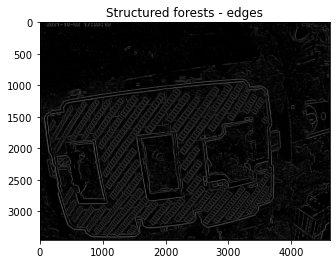

In [9]:
plt.title('Structured forests - edges')
plt.imshow(sf, cmap='gray')
plt.show()

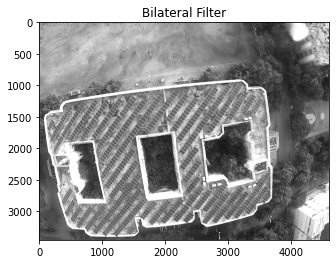

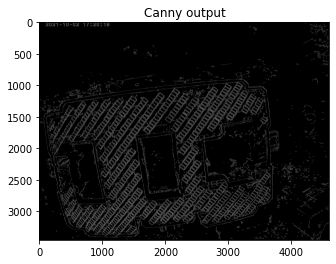

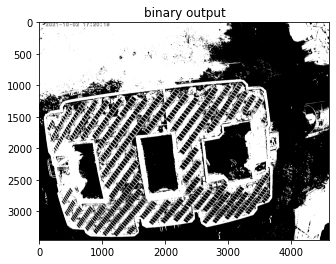

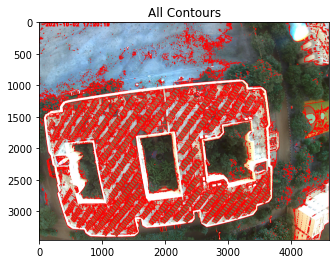

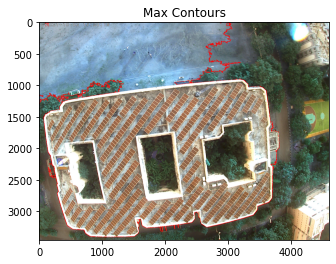

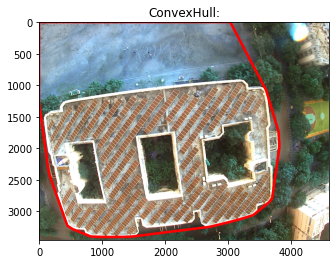

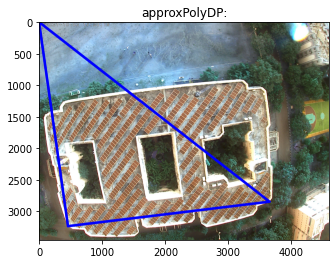

In [6]:
# plots 
plt.title('Bilateral Filter')
plt.imshow(blur, cmap='gray')
plt.show()

plt.title('Canny output')
plt.imshow(canny, cmap='gray')
plt.show()

plt.title('binary output')
plt.imshow(thresh1, cmap='gray')
plt.show()

# plt.title('dilated output')
# plt.imshow(dilated)
# plt.show()

# plt.title('eroded output')
# plt.imshow(eroded)
# plt.show()

plt.title('All Contours')
plt.imshow(imgCopy3, cmap='gray')
plt.show()

plt.title('Max Contours')
plt.imshow(imgCopy2, cmap='gray')
plt.show()

# Display the final convex hull image
plt.title('ConvexHull:')
plt.imshow(imgCopy4, cmap='gray')
plt.show()

plt.title('approxPolyDP:')
plt.imshow(imgCopy5, cmap='gray')
plt.show()


<ipython-input-11-f25922ed5ada>:9: RuntimeWarning: invalid value encountered in sqrt
  perimeters.append(np.sqrt((x2-x1)^2 + (y2-y1)^2))


nan
0
[[[1273 2675 1295 2647]]

 [[1371 2262 1375 2257]]

 [[1391 3005 1392 3005]]

 ...

 [[2403 2921 2404 2921]]

 [[1691 2261 1691 2262]]

 [[3258 2878 3261 2876]]]


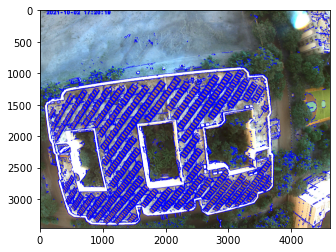

In [11]:
# Hough Transform
lines = cv2.HoughLinesP(canny, 1, np.pi/180, 40) #, maxLineGap=250
imgCopy1 = np.copy(img)
perimeters = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(imgCopy1, (x1, y1), (x2, y2), (0, 0, 255), 5) #blue
    #perimeters.append(cv2.arcLength(line,True))
    perimeters.append(np.sqrt((x2-x1)^2 + (y2-y1)^2))

print(max(perimeters))
maxindex= perimeters.index(max(perimeters))
print(maxindex)
imgCopy2 = np.copy(img)
print(lines)
x1 = lines[maxindex][0][0]
x2 = lines[maxindex][0][2]
y1 = lines[maxindex][0][1]
y2 = lines[maxindex][0][3]

cv2.line(imgCopy2, (x1, y1), (x2, y2), (0, 0, 255), 50) #blue
   
# lines = cv2.HoughLines(edges, 1, np.pi/180, 50)
# print(lines)
# for line in lines:
#     rho,theta = line[0]
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + 10000*(-b))
#     y1 = int(y0 + 10000*(a))
#     x2 = int(x0 - 10000*(-b))
#     y2 = int(y0 - 10000*(a))
#     cv2.line(img,(x1,y1),(x2,y2),(255,0,0),1)

plt.imshow(imgCopy1)
plt.show()


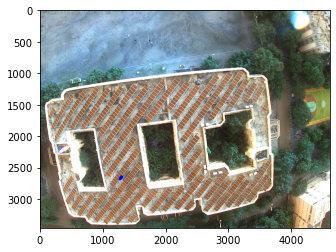

In [12]:
plt.imshow(imgCopy2)
plt.show()

## Hough Transform + Polygon Approximation

In [ ]:
rows, cols, _ = img.shape
white_img = cv2.bitwise_not(np.zeros(img.shape, np.uint8))
white_polygon = cv2.bitwise_not(np.zeros(img.shape, np.uint8))
white_gray = cv2.cvtColor(white_img, cv2.COLOR_BGR2GRAY)
white_polygon_copy = cv2.bitwise_not(np.zeros(img.shape, np.uint8))


## Blurring 
# blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# plt.title('Blurred output')
# plt.imshow(blurred)
# plt.show()

# canny = auto_canny(blurred)
# plt.title('canny output')
# plt.imshow(canny)
# plt.show()
# dilated = cv2.dilate(canny, np.ones((3,3), dtype=np.uint8))
# plt.title('dilated output')
# plt.imshow(dilated)
# plt.show()

HT = 100 # Hough Threshold
IT = 170 # Intensity Threshold
lines = cv2.HoughLinesP(canny, 1, np.pi / 180, HT)
print(lines)

#lines = np.reshape(lines, (lines.shape[0], lines.shape[2]))
#print(lines)

imgCopy1 = np.copy(img)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(imgCopy1, (x1, y1), (x2, y2), (0, 0, 255), 5) #blue


plt.imshow(imgCopy1)
plt.show()



[2.604606e+03 9.736469e-01]
[-1780.7227        2.7610135]
[1.3437893e+03 1.3240997e+00]
[3.3157334e+03 7.6046777e-01]
[-110.70349      2.4280596]
[-2814.239        2.943275]
[1.9492772e+03 1.1448872e+00]
[4.1004092e+03 6.4579344e-01]
[-897.4751       2.6228447]
[656.16315     1.7889552]


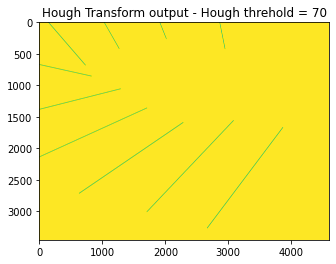

ValueError: dictionary update sequence element #0 has length 1; 2 is required

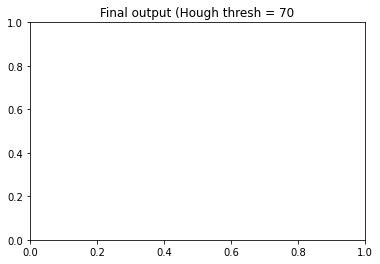

In [8]:
lines = cv2.HoughLines(canny, 1, np.pi / 180, HT)
lines = np.reshape(lines, (lines.shape[0], lines.shape[2]))

kmeans = KMeans(n_clusters=10).fit(lines)

for line in kmeans.cluster_centers_:
    print(line)
    #rho = line[0]
    #theta = line[1]
    rho,theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * a)
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * a)
    cv2.line(white_gray, (x1, y1), (x2, y2), 0, 2)

contours = cv2.findContours(white_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

plt.title('Hough Transform output - Hough threhold = ' + str(HT))
plt.imshow(white_gray)
plt.show()

######################################## CASE1 #######################################################
for cnt in contours:
    cv2.drawContours(white_polygon, cnt, 0, 0, -1)
    man = []
    intense = []
    for col in range(cols):
        for row in range(rows):
            if cv2.pointPolygonTest(cnt, (col, row), False) == 1:
                man.append((row, col))
    for k in man:
        intense.append(img[k])
    intensity = mean(intense)
#     print (intensity)
    if intensity > IT:
        cv2.drawContours(white_polygon, [cnt], 0, 0, -1)

white_gray1 = cv2.cvtColor(white_polygon, cv2.COLOR_BGR2GRAY)
opened = opening(white_gray1, selem=disk(4))
plt.title('Final output (Hough thresh = ' + str(HT) , 'intensity thresh = ' + str(IT))
plt.imshow(opened, cmap='gray')
plt.show()